resnet1dの過学習を抑える

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


# データ用意

In [16]:
fold = "../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz.npy")
gyr_xyz = np.load(f"{fold}gyr_xyz.npy")
mag_xyz = np.load(f"{fold}mag_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)
print(acc_xyz.shape)
print(gyr_xyz.shape)
print(mag_xyz.shape)
print(xyz.shape)
print(label.shape)

(196072, 3, 500)
(196072, 3, 500)
(196072, 3, 500)
(196072, 9, 500)
(196072,)


In [17]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = xyz.reshape(-1, xyz.shape[-1])  # (196072*3, 500)

scaled_xyz = scaler.fit_transform(xyz_reshaped)  # 標準化

scaled_xyz = scaled_xyz.reshape(xyz.shape)  # 元の形に戻す

print(scaled_xyz.shape)  # (196072, 3, 500)


(196072, 9, 500)


In [6]:
xyz_reshaped = []

In [18]:
#おしり3万データを使う  
xyz = scaled_xyz[-40000:-10000,:]
label = label[-40000:-10000]
print(xyz.shape)
print(label.shape)

(30000, 9, 500)
(30000,)


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(xyz, label, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
# train_randomの生成
#train_xyz_random = train_xyz
#train_label_random = train_label

Train data shape: (24000, 9, 500)
Test data shape: (6000, 9, 500)
Train label shape: (24000,)
Test label shape: (6000,)
1.0    4235
4.0    3917
7.0    3893
6.0    3582
2.0    3010
5.0    2964
8.0    1445
3.0     954
Name: count, dtype: int64
1.0    1041
7.0     964
4.0     960
6.0     926
5.0     774
2.0     719
8.0     373
3.0     243
Name: count, dtype: int64


In [5]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    
    #データセットをバッチサイズごとに分割
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')

        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch-1)
            yield X_batch, y_batch


def forward_by_batches(cnn, X):
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y


def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y-1.0).type(torch.int64).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

# モデル定義

In [23]:
class BasicBlock1d(nn.Module):
    expansion = 1

    def __init__(
            self, 
            in_planes, 
            planes, 
            
            stride=1,
            dropout=0.0):
        
        super(BasicBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu1 = nn.ReLU(True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.relu2 = nn.ReLU(True)
        

        self.downsample = None
        # 以下はスキップ接続のための入力xのリサンプリング
        if stride != 1 or in_planes != self.expansion*planes:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        skipX = x
        #out = self.bn1(self.conv1(x))
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)# ここでreluまで通す
        out = self.conv2(out)
        out = self.bn2(out)
        if self.dropout is not None:
            out = self.dropout(out)
        #out = self.bn2(self.conv2(out)) # ここでbn2まで通す
        if self.downsample is not None:
            skipX = self.downsample(x)
        out += skipX # ここでスキップ接続する。加算
        out = self.relu2(out)
        #out = F.relu(out)
        return out

class ResNet1d(nn.Module):
    def __init__(self, block, num_blocks, dropout=0.0, num_classes=8):
        super(ResNet1d, self).__init__()
        self.in_planes = 64 # resnet18に合わせる
        self.dropout = dropout

        self.conv1 = nn.Conv1d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool1d(3,2,1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # strideを２にするブロックがある場合はstride=2を指定する
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout=self.dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        #out = F.avg_pool1d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18_1d():
    return ResNet1d(BasicBlock1d, [2, 2, 2, 2])


In [41]:
lr = 1e-4
#resnet = ResNet18_1d().to(device)
resnet = ResNet1d(BasicBlock1d, [2,2,2,2],dropout=0).to(device)
print(resnet) # ここではcnnのネットワーク構造の定義をして、そのネットワークの構造をprintしている。

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー損失を使用してモデルの出力と実際のラベルとの差を計算するためのインスタンス定義
optimizer = optim.Adam(resnet.parameters(), lr=lr,weight_decay=1e-3) # オプティマイザーを使用し、設定された学習率lrでモデルのパラメータを最適化する。Adamはよく使われるやつでパフォーマンスが高いらしい　
# optim.Adam()ではcnnのパラメータへの直接参照をすることができるnum_filters
# 学習率スケジューラの定義
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

ResNet1d(
  (conv1): Conv1d(9, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReL

In [42]:
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
num_epoch = 100
batch_size = 64  # size of the mini-batch　バッチサイズを64にしている 64が今のところ最高評価
count = 0
for i in tqdm(range(num_epoch)): # 同じデータセットでnum_epoch回cnnを学習させている。
    if i!=0:
        if loss.item() < 0.1 and count==0:
            batch_size = 2048
            count += 1
            print(f"batch_size:{batch_size}, count:{count}")
        if count!=0:
            count +=1
        if count == 25:
            batch_size = batch_size*2
            #count+=1
            print(f"batch_size:{batch_size}, count:{count}")
        if count == 50:
            print("break!")
            break
        

    dataloader = create_dataloader(train_xyz, train_label, int(batch_size), shuffle=True)
    

    for x, target in dataloader:
        x, target = x.to(device), target.type(torch.int64).to(device) # ここでdeviceにデータを移行
        resnet.zero_grad()
        output = resnet(x) # バッチxをネットワークに通し、予測値outputを取得
        loss = loss_fn(output, target) # 予測値と実際のラベルtargetとの間の損失を計算する。ネットワークの出力outputと正解targetとの間の差異を計算しその結果としてスカラー値lossを生成する。
        loss.backward() # 計算されたlossに従ってネットワークのすべてのパラメータに対する勾配が計算される。
        optimizer.step() # オプティマイザが保存している勾配情報を使用してモデルのパラメータを更新　直接cnnに紐づいているのでcnnのパラメータを直接更新している

        # Logging -- track train loss
        losses.append(loss.item()) # ログを残している。lossというのはパラメータのgradientでパラメータを更新する方向や大きさを決めている。

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    #scheduler.step()  # エポックの終わりに学習率を調整

    # Logging -- average train loss in this epoch
    loss_history_train.append(utils.ewm(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(resnet, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
     # エポックごとの損失や精度を記録
    print(f"Epoch {i+1}/{num_epoch}, Loss: {loss.item()}, test Loss:{results['loss']}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.5149412155151367, test Loss:0.6752088665962219
Epoch 2/100, Loss: 0.7102360129356384, test Loss:0.5202953815460205
Epoch 3/100, Loss: 0.44153547286987305, test Loss:0.45322710275650024
Epoch 4/100, Loss: 0.47573429346084595, test Loss:0.3748995363712311
Epoch 5/100, Loss: 0.335571825504303, test Loss:0.3563152253627777
Epoch 6/100, Loss: 0.3797300457954407, test Loss:0.35858431458473206
Epoch 7/100, Loss: 0.33421576023101807, test Loss:0.3560487926006317
Epoch 8/100, Loss: 0.41138434410095215, test Loss:0.3369535207748413
Epoch 9/100, Loss: 0.3634323477745056, test Loss:0.30445125699043274
Epoch 10/100, Loss: 0.2877407371997833, test Loss:0.3138478398323059
Epoch 11/100, Loss: 0.4079207181930542, test Loss:0.2977205514907837
Epoch 12/100, Loss: 0.27793756127357483, test Loss:0.28330591320991516
Epoch 13/100, Loss: 0.3148424029350281, test Loss:0.2788640260696411
Epoch 14/100, Loss: 0.3249015212059021, test Loss:0.2639662027359009
Epoch 15/100, Loss: 0.4312235116958

In [44]:
results

{'loss': 0.15614953637123108,
 'kappa': 0.9448244044767483,
 'Y_pred': array([7, 4, 3, ..., 6, 6, 7], dtype=int64)}

モデルの保存

In [14]:
model_save_path = "../models/resnet_v11_all.pth"
torch.save(resnet.state_dict(), model_save_path)

以下はドロップアウトなし


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.93      0.96      0.95      1041
         2.0       0.98      0.97      0.97       719
         3.0       1.00      1.00      1.00       243
         4.0       0.99      0.98      0.98       960
         5.0       0.97      0.96      0.97       774
         6.0       0.95      0.94      0.94       926
         7.0       0.92      0.93      0.92       964
         8.0       0.89      0.87      0.88       373

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



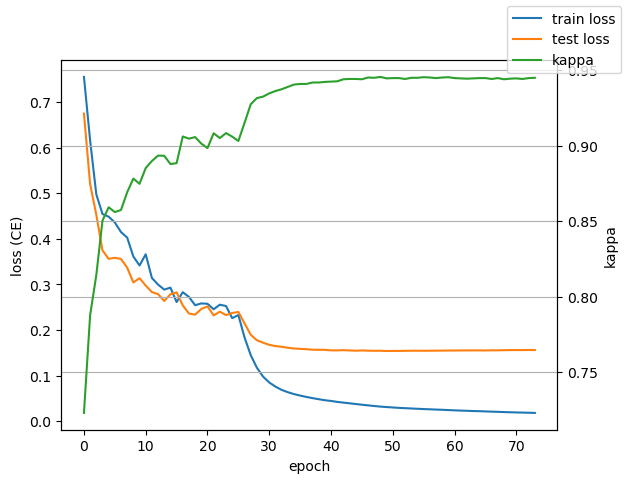

In [43]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.93      0.94      0.94      1041
         2.0       0.92      0.94      0.93       719
         3.0       0.99      0.98      0.99       243
         4.0       0.98      0.97      0.98       960
         5.0       0.95      0.93      0.94       774
         6.0       0.91      0.91      0.91       926
         7.0       0.90      0.90      0.90       964
         8.0       0.86      0.84      0.85       373

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



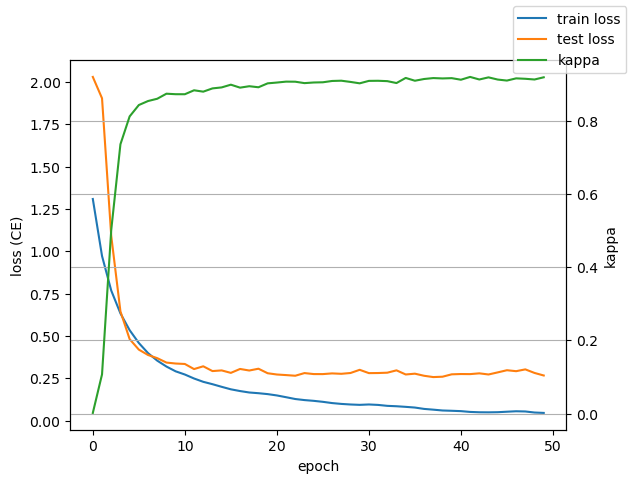

In [22]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))

以下はドロップアウト0.2


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.66      0.97      0.79      1041
         2.0       0.98      0.67      0.79       719
         3.0       1.00      0.98      0.99       243
         4.0       1.00      0.79      0.88       960
         5.0       0.91      0.86      0.88       774
         6.0       0.87      0.86      0.86       926
         7.0       0.81      0.82      0.81       964
         8.0       0.76      0.74      0.75       373

    accuracy                           0.83      6000
   macro avg       0.87      0.84      0.85      6000
weighted avg       0.86      0.83      0.84      6000



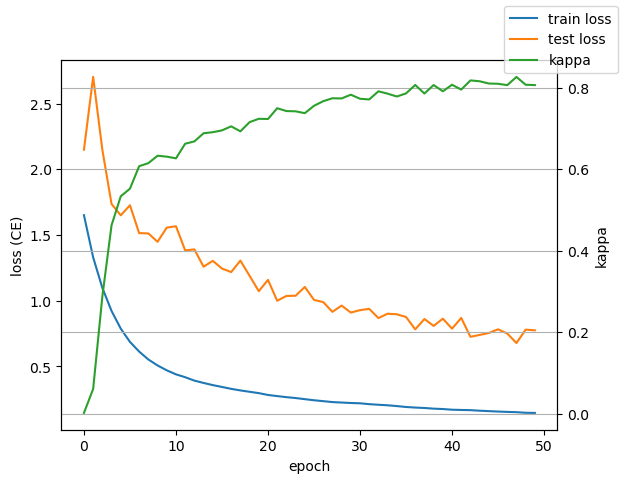

In [29]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))

以下はドロップアウト0.5  
epoch100までのものは無視して　過去の学習の履歴が残ったままになってるだけ


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.72      0.86      0.78      1041
         2.0       0.95      0.96      0.95       719
         3.0       1.00      1.00      1.00       243
         4.0       0.99      0.97      0.98       960
         5.0       0.87      0.89      0.88       774
         6.0       0.91      0.80      0.85       926
         7.0       0.81      0.73      0.77       964
         8.0       0.67      0.64      0.65       373

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



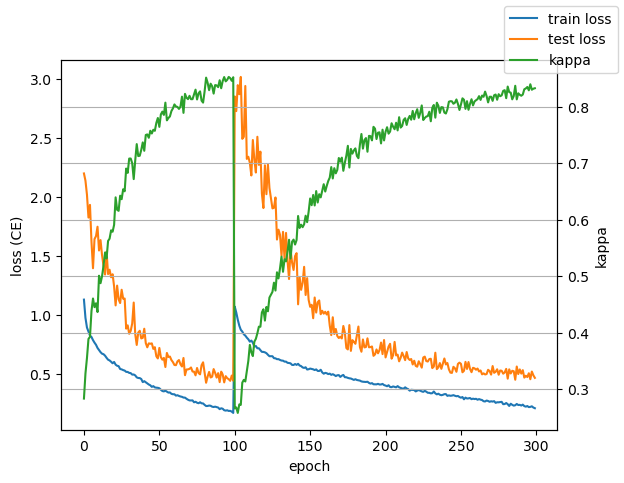

In [75]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))

resnetにはドロップアウトが効果的ではないかもしれない。  
収束が遅くなるだけのような？ほかの手法はないかね